In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
from pathlib import Path
import pylangacq

In [633]:
# Load the corpora into individual readers, plus a combined reader.
# Loading may take several seconds.

data_path = Path('data')
corpora_paths = sorted(data_path.glob('*.zip'), key=lambda x: x.name.lower())
corpora_names = [path.stem for path in corpora_paths]

readers = {name: pylangacq.read_chat(str(path)) for name, path in zip(corpora_names, corpora_paths)}

In [634]:
readers['Champaign'].tokens()  # Champaign not POS tagged!

[Token(word='here', pos=None, mor=None, gra=None),
 Token(word=',', pos=None, mor=None, gra=None),
 Token(word='do', pos=None, mor=None, gra=None),
 Token(word='you', pos=None, mor=None, gra=None),
 Token(word='want', pos=None, mor=None, gra=None),
 Token(word='some', pos=None, mor=None, gra=None),
 Token(word='help', pos=None, mor=None, gra=None),
 Token(word='?', pos=None, mor=None, gra=None),
 Token(word='can', pos=None, mor=None, gra=None),
 Token(word='you', pos=None, mor=None, gra=None),
 Token(word='get', pos=None, mor=None, gra=None),
 Token(word='up', pos=None, mor=None, gra=None),
 Token(word='there', pos=None, mor=None, gra=None),
 Token(word='?', pos=None, mor=None, gra=None),
 Token(word='uhhuh', pos=None, mor=None, gra=None),
 Token(word='.', pos=None, mor=None, gra=None),
 Token(word='↫w↫which', pos=None, mor=None, gra=None),
 Token(word='color', pos=None, mor=None, gra=None),
 Token(word='plate', pos=None, mor=None, gra=None),
 Token(word='do', pos=None, mor=None, gra=N

In [ ]:
# Note: something about the HSLLD corpus is causing unexpected things to happen when analyzing the data in aggregate.

In [635]:
# Ages range from 21-145 months, and for now we are bucketing every 3 months.

lowest_age  = 21
highest_age = 145
increment   = 3

age_buckets = list(range(lowest_age, highest_age + increment, increment))
readers_by_age = {age: pylangacq.Reader() for age in age_buckets}

In [636]:
# Reorganize corpora readers into readers per age bucket, combining corpora at ages if necessary.
# TODO: where are ages of 0 coming from?

for corpus_name, reader in readers.items():
    while True:
        try:
            single_instance_reader = reader.pop()
            
            age = single_instance_reader.ages(months=True)[0]
            if age is None:
                continue
            age_bucket = round(age / increment) * increment
            if age_bucket not in age_buckets:
                print('Discarding age of', age)
                continue
            
            readers_by_age[age_bucket].append(single_instance_reader)
        except IndexError:
            break

Discarding age of 0.0
Discarding age of 0.0
Discarding age of 0.0
Discarding age of 0.0
Discarding age of 0.0
Discarding age of 0.0
Discarding age of 0.0


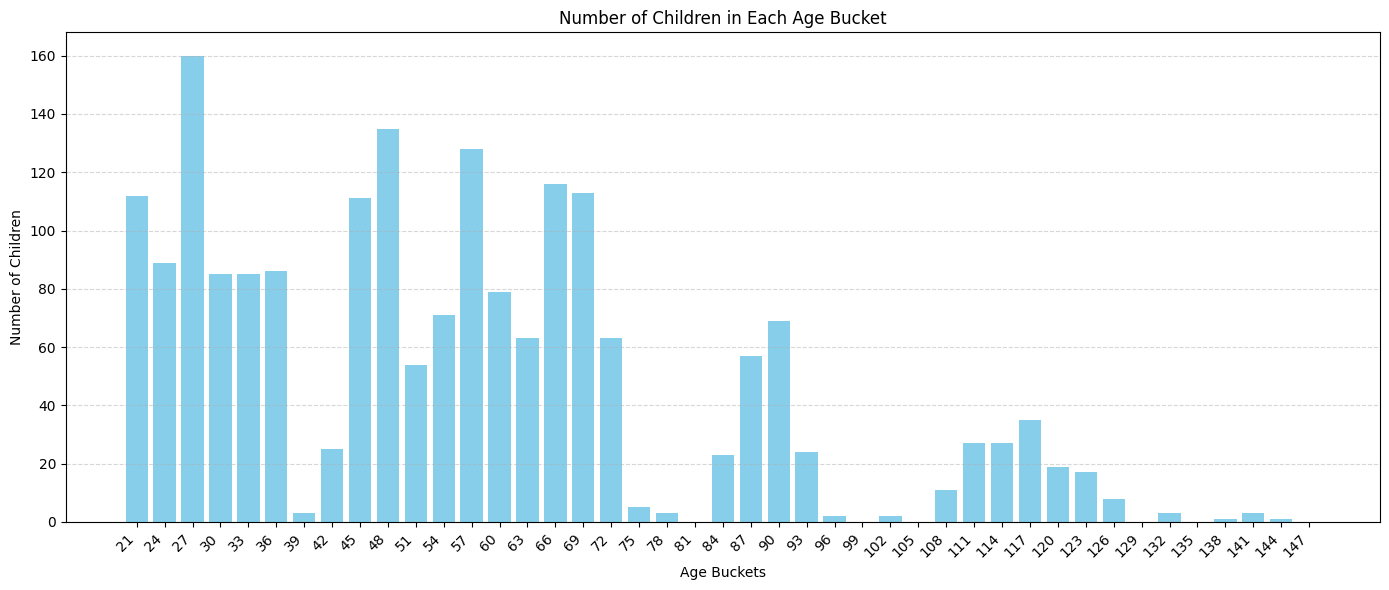

In [637]:
# Plot the number of children in each age bucket.

age_counts = [(age, len(r.ages())) for age, r in readers_by_age.items() if r is not None]
ages = [str(age) for age, _ in age_counts]
counts = [count for _, count in age_counts]

plt.figure(figsize=(14, 6))  # Increase figure size for clarity
plt.bar(ages, counts, color='skyblue')  # Use a visually appealing color

# Customize the plot
plt.xticks(rotation=45, ha='right')  # Rotate x-tick labels for better legibility
plt.xlabel('Age Buckets')
plt.ylabel('Number of Children')
plt.title('Number of Children in Each Age Bucket')
plt.grid(axis='y', linestyle='--', alpha=0.5)  # Add horizontal grid lines

# Adjust the layout
plt.tight_layout()  # Prevent x-tick labels from being cut off

plt.show()

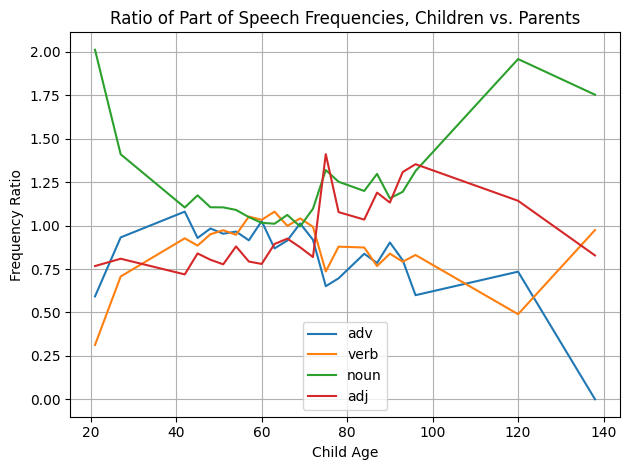

In [642]:
# Calculate custom metrics and analysis on the extracted data.
# WARNING: the Champaign corpus (and maybe others) are not POS-tagged, so this will not work for them.

pos_of_interest = ['noun', 'verb', 'adj', 'adv']
ratios = {age: {pos: 0 for pos in pos_of_interest} for age in age_buckets}

for age, reader in readers_by_age.items():
        child_word_count  = len([t for t in reader.tokens(participants=['CHI'])        if t.pos in pos_of_interest])
        parent_word_count = len([t for t in reader.tokens(participants=['MOT', 'FAT']) if t.pos in pos_of_interest])
        for pos in pos_of_interest:
            child_pos_count  = len([t.pos for t in reader.tokens(participants=['CHI'])        if t.pos == pos])
            parent_pos_count = len([t.pos for t in reader.tokens(participants=['MOT', 'FAT']) if t.pos == pos])

            child_rel_freq  = child_pos_count  / child_word_count  if child_word_count  > 0 else 0
            parent_rel_freq = parent_pos_count / parent_word_count if parent_word_count > 0 else 0

            ratios[age][pos] = child_rel_freq / parent_rel_freq if parent_rel_freq > 0 else 0

# Remove any None entries.
ratios = {age: pos_ratios for age, pos_ratios in ratios.items() if any(pos_ratios.values())}

# Filter keys to ignore any integer keys above a threshold
x = [key for key in ratios.keys() if key <= 100000]  # Don't use a threshold for now
all_labels = set().union(*(d.keys() for d in ratios.values()))

for label in all_labels:  # Iterate over all unique string keys
    y = [ratios[key].get(label, 0) for key in x]  # Get value or 0 if missing
    plt.plot(x, y, label=label)

# Plot settings
plt.title('Ratio of Part of Speech Frequencies, Children vs. Parents')
plt.xlabel('Child Age')
plt.ylabel('Frequency Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [643]:
# Print common nouns

for age, reader in readers_by_age.items():
    print(Counter([t.word for t in reader.tokens(participants=['CHI']) if t.pos == 'noun']).most_common(10))

[('ball', 82), ('chair', 23), ('O', 16), ('bed', 15), ('people', 14), ('chicken', 13), ('Mommy', 12), ('dog', 11), ('teacher', 11), ('car', 10)]
[]
[('house', 68), ('one', 49), ('bird', 43), ('bed', 42), ('Miffy', 41), ('snow', 35), ('hat', 29), ('Mommy', 29), ('snowman', 27), ('window', 24)]
[]
[('car', 8), ('mommy', 6), ('mirror', 6), ('bottle', 6), ('baby', 4), ('one', 4), ('phone', 4), ('snake', 3), ('time', 3), ('curtains', 3)]
[('baby', 50), ('car', 24), ('truck', 23), ('school', 16), ('minute', 12), ('motor', 12), ('tractor', 12), ('Sunday', 11), ('dinner', 10), ('Daddy', 10)]
[('snake', 9), ('Superman', 9), ('one', 7), ('coffee', 7), ('baby', 6), ('comb', 6), ('truck', 5), ('hands', 5), ('side', 4), ('key', 4)]
[('zzz', 46), ('one', 30), ('baby', 25), ('snake', 21), ('ice', 19), ('piece', 19), ('cat', 19), ('cream', 18), ('car', 15), ('mommy', 15)]
[('zzz', 436), ('Mom', 142), ('one', 133), ('Mommy', 101), ('cat', 95), ('car', 93), ('dog', 88), ('Mama', 58), ('school', 57), ('b

In [644]:
# Print common verbs

for age, reader in readers_by_age.items():
    print(Counter([t.word for t in reader.tokens(participants=['CHI']) if t.pos == 'verb']).most_common(10))

[('go', 11), ('done', 7), ('see', 5), ('sit', 5), ('do', 3), ('play', 3), ('goes', 3), ('get', 2), ('look', 2), ('want', 2)]
[]
[('go', 126), ('want', 41), ('get', 38), ('see', 37), ('know', 31), ('going', 23), ('put', 22), ('play', 21), ('come', 19), ('do', 18)]
[]
[('know', 14), ('go', 9), ('get', 9), ('have', 6), ('POSTCLITIC', 5), ('work', 5), ('put', 5), ('do', 4), ('call', 4), ('clean', 4)]
[('get', 44), ('go', 32), ('have', 28), ('drive', 25), ('put', 20), ('let', 20), ('see', 18), ('got', 11), ('want', 11), ('know', 9)]
[('want', 16), ('put', 10), ('have', 10), ('broken', 10), ('going', 8), ('locked', 7), ('see', 7), ('goes', 7), ('clap', 7), ('cut', 7)]
[('go', 56), ('have', 48), ('get', 46), ('going', 45), ('put', 41), ('know', 32), ('need', 32), ('come', 30), ('see', 28), ('want', 26)]
[('want', 268), ('go', 258), ('know', 180), ('get', 149), ('have', 137), ('do', 128), ('put', 127), ('see', 124), ('got', 97), ('eat', 97)]
[('know', 228), ('go', 205), ('want', 198), ('eat', 

In [645]:
# Print common adjectives

for age, reader in readers_by_age.items():
    print(Counter([t.word for t in reader.tokens(participants=['CHI']) if t.pos == 'adj']).most_common(10))

[('more', 6), ('big', 5), ('good', 3), ('open', 3), ('little', 3), ('nice', 2), ('high', 2), ('square', 2), ('other', 1), ('asleep', 1)]
[]
[('more', 36), ('little', 20), ('good', 19), ('cold', 12), ('red', 11), ('orange', 10), ('big', 8), ('yellow', 7), ('sad', 7), ('green', 7)]
[]
[('more', 2), ('big', 2), ('tired', 2), ('okay', 2), ('tiny', 2), ('sure', 2), ('least', 2), ('good', 2), ('gracious', 1), ('tiger', 1)]
[('ready', 21), ('little', 8), ('big', 6), ('nice', 5), ('sick', 5), ('okay', 5), ('good', 4), ('new', 3), ('hot', 3), ('right', 2)]
[('other', 6), ('wrong', 2), ('better', 2), ('enough', 1), ('more', 1), ('yummy', 1), ('scrumptious', 1), ('sorry', 1), ('dirty', 1), ('big', 1)]
[('more', 28), ('other', 17), ('okay', 14), ('green', 13), ('red', 12), ('big', 11), ('yellow', 9), ('good', 8), ('blue', 7), ('orange', 6)]
[('big', 111), ('more', 78), ('little', 69), ('good', 58), ('yellow', 45), ('blue', 41), ('red', 40), ('green', 39), ('hot', 34), ('black', 33)]
[('big', 100),

In [646]:
# Print common adverbs

for age, reader in readers_by_age.items():
    print(Counter([t.word for t in reader.tokens(participants=['CHI']) if t.pos == 'adv']).most_common(10))

[('where', 20), ('there', 12), ('here', 6), ('in', 6), ("where's", 5), ('right', 4), ('up', 2), ('too', 2), ('why', 1), ('down', 1)]
[]
[('there', 99), ('here', 98), ('where', 68), ('right', 61), ('now', 22), ('in', 22), ('down', 17), ('too', 15), ("where's", 15), ('up', 14)]
[]
[('now', 22), ('here', 10), ('there', 7), ('then', 6), ('gonna', 5), ('just', 5), ('around', 4), ('on', 3), ('where', 3), ('back', 2)]
[('here', 37), ('right', 20), ('gonna', 20), ('there', 17), ("here's", 17), ('now', 15), ('where', 14), ('down', 8), ('away', 8), ('too', 7)]
[('here', 29), ('there', 16), ('then', 12), ('why', 6), ('better', 5), ("where's", 4), ('right', 4), ('just', 3), ('now', 3), ('away', 3)]
[('here', 61), ('now', 60), ('there', 46), ('too', 32), ('right', 26), ('then', 26), ('where', 23), ('gonna', 20), ("where's", 16), ('on', 13)]
[('here', 220), ('there', 181), ('gonna', 134), ('why', 124), ('now', 113), ('right', 111), ('where', 106), ('how', 81), ('too', 78), ('then', 71)]
[('here', 24

In [532]:
# Get n-grams (exclude punctuation)

def get_ngrams(df, reader, pos_counter, ngram_counter):
    filter_punctuation = lambda ngram: all([word not in ['.', '?', '!', '...'] for word in ngram])

    ngram_counter['bigrams'  ] = {ngram: count for ngram, count in reader.word_ngrams(participants='CHI', n=2).items() if filter_punctuation(ngram)}
    ngram_counter['trigrams' ] = {ngram: count for ngram, count in reader.word_ngrams(participants='CHI', n=3).items() if filter_punctuation(ngram)}
    ngram_counter['quadgrams'] = {ngram: count for ngram, count in reader.word_ngrams(participants='CHI', n=4).items() if filter_punctuation(ngram)}

apply_extraction(get_ngrams, corpora_statistics)

,avg_age_mo,words_raw_chi,words_pp_chi,unique_words_pp_chi,adjs_chi,nouns_chi,verbs_chi,words_raw_par,words_pp_par,unique_words_pp_par,adjs_par,nouns_par,verbs_par
0,55.79,1270881,544668,12786,71706,235596,115431,1949811,821947,16778,133907,351029,193056


In [533]:
# Display common bigrams

corpora_ngram_counters['Combined']['bigrams']

{('little', 'girl'): 40,
 ('that', 'baby'): 46,
 ('ball', 'oh'): 1,
 ('where', 'ball'): 12,
 ('right', 'in'): 110,
 ('in', 'there'): 1296,
 ('out', 'ball'): 1,
 ('ball', 'huh'): 2,
 ('ah', 'ah'): 197,
 ('oh', 'ball'): 1,
 ('ball', 'go'): 5,
 ('ball', 'ball'): 2,
 ("what's", 'that'): 526,
 ('good', 'Mommy'): 3,
 ('no', 'Mommy'): 8,
 ('uhhuh', 'in'): 1,
 ('see', 'ya'): 6,
 ('my', 'chicken'): 17,
 ('too', 'big'): 108,
 ('little', 'chair'): 5,
 ('throw', 'them'): 11,
 ('them', 'in'): 126,
 ('too', 'high'): 7,
 ('it', 'goes'): 257,
 ('goes', 'in'): 119,
 ('right', 'here'): 1182,
 ('I', "can't"): 922,
 ("can't", 'open'): 33,
 ('no', 'I'): 570,
 ('where', 'people'): 2,
 ('people', 'go'): 13,
 ('daddy', 'daddy'): 11,
 ('another', 'baby'): 24,
 ('he', 'been'): 5,
 ('been', 'asleep'): 1,
 ('this', 'one'): 1930,
 ('one', 'shut'): 1,
 ('come', 'out'): 130,
 ('out', 'there'): 65,
 ('there', 'car'): 1,
 ('open', 'the'): 95,
 ('the', 'door'): 240,
 ('where', 'do'): 38,
 ('another', 'chair'): 14,
 ('c

In [534]:
# Display common trigrams

corpora_ngram_counters['Combined']['trigrams']

{('right', 'in', 'there'): 25,
 ('out', 'ball', 'huh'): 1,
 ('oh', 'ball', 'go'): 1,
 ('where', 'ball', 'go'): 1,
 ('uhhuh', 'in', 'there'): 1,
 ('throw', 'them', 'in'): 4,
 ('it', 'goes', 'in'): 29,
 ('goes', 'in', 'there'): 30,
 ('I', "can't", 'open'): 24,
 ('no', 'I', "can't"): 28,
 ('where', 'people', 'go'): 2,
 ('he', 'been', 'asleep'): 1,
 ('this', 'one', 'shut'): 1,
 ('come', 'out', 'there'): 2,
 ('out', 'there', 'car'): 1,
 ('open', 'the', 'door'): 47,
 ('chair', 'there', 'is'): 1,
 ('I', "don't", 'know'): 1661,
 ('in', 'high', 'in'): 1,
 ('the', 'other', 'one'): 141,
 ('ah', 'doggie', 'get'): 1,
 ('doggie', 'get', 'in'): 1,
 ('no', 'no', 'no'): 147,
 ('in', 'a', 'ride'): 1,
 ("where's", 'the', 'ball'): 9,
 ("where's", 'the', 'car'): 2,
 ('this', 'a', 'ball'): 1,
 ('where', 'the', 'ball'): 4,
 ('want', 'the', 'ball'): 3,
 ('a', 'mommy', 'go'): 1,
 ('mommy', 'go', 'to'): 2,
 ('this', 'seen', 'ball'): 1,
 ('there', 'want', 'a'): 1,
 ('want', 'a', 'ball'): 2,
 ('a', 'a', 'ball'): 

In [535]:
# Display common quadgrams

corpora_ngram_counters['Combined']['quadgrams']

{('it', 'goes', 'in', 'there'): 7,
 ('come', 'out', 'there', 'car'): 1,
 ('ah', 'doggie', 'get', 'in'): 1,
 ('a', 'mommy', 'go', 'to'): 1,
 ('there', 'want', 'a', 'ball'): 1,
 ('up', 'up', 'up', 'up'): 3,
 ('I', 'need', 'a', 'ride'): 1,
 ('take', 'it', 'all', 'out'): 3,
 ('this', 'go', 'in', 'here'): 4,
 ('it', 'went', 'in', 'here'): 2,
 ('where', 'is', 'the', 'doggie'): 1,
 ("where's", 'the', 'little', 'baby'): 1,
 ('what', 'does', 'baby', 'say'): 1,
 ('what', 'does', 'doggie', 'say'): 1,
 ('what', 'does', 'doggie', 'says'): 1,
 ('this', 'is', 'hard', 'work'): 2,
 ("where's", 'other', 'over', 'there'): 1,
 ('puts', 'man', 'at', 'bottom'): 1,
 ('man', 'at', 'bottom', 'of'): 1,
 ('at', 'bottom', 'of', 'ladder'): 1,
 ('bottom', 'of', 'ladder', 'and'): 1,
 ('of', 'ladder', 'and', 'then'): 1,
 ('ladder', 'and', 'then', 'walks'): 1,
 ('and', 'then', 'walks', 'him'): 1,
 ('then', 'walks', 'him', 'up'): 1,
 ('walks', 'him', 'up', 'one'): 1,
 ('him', 'up', 'one', 'step'): 1,
 ('up', 'one', 'st

In [536]:
# Get word frequency comparisons between children and parents
# This is expected to raise RuntimeWarnings for divisions-by-zero since the Garvey corpus has no parent participants.

# Note/hypothesis:
# Child saying more nouns and fewer verbs and adjectives (relative to themselves) than parents
#   --> Parent is driving the play narrative (e.g. "the doll is going to dinner"),
#       while child is reacting, especially to prompts by parent,
#       (e.g. "what is the doll eating? [verb]" --> "bread" [noun])
# Also, saying fewer adjectives may indicate that the child is less descriptive than an adult

def get_parent_child_word_frequencies_comparisons(df, reader, pos_counter, ngram_counter):
    df['pct_nouns_chi' ] = round(df['nouns_chi'].sum() / df['words_pp_chi'].sum(), 2)
    df['pct_verbs_chi' ] = round(df['verbs_chi'].sum() / df['words_pp_chi'].sum(), 2)
    df['pct_adjs_chi'  ] = round(df['adjs_chi' ].sum() / df['words_pp_chi'].sum(), 2)

    df['pct_nouns_par' ] = round(df['nouns_par'].sum() / df['words_pp_par'].sum(), 2)
    df['pct_verbs_par' ] = round(df['verbs_par'].sum() / df['words_pp_par'].sum(), 2)
    df['pct_adjs_par'  ] = round(df['adjs_par' ].sum() / df['words_pp_par'].sum(), 2)

    df['pct_spoken_chi']       = round(df['words_pp_chi'].sum() / (df['words_pp_chi'].sum() + df['words_pp_par'].sum()), 2)
    df['rat_chi_nouns_to_par'] = round(df['pct_nouns_chi'] / df['pct_nouns_par'], 2)
    df['rat_chi_verbs_to_par'] = round(df['pct_verbs_chi'] / df['pct_verbs_par'], 2)
    df['rat_chi_adjs_to_par' ] = round(df['pct_adjs_chi' ] / df['pct_adjs_par' ], 2)

apply_extraction(get_parent_child_word_frequencies_comparisons, corpora_statistics)

/var/folders/cx/nbz8tq511x96rngcrp3c35zm0000gn/T/ipykernel_90582/1281058627.py:16: RuntimeWarning: invalid value encountered in scalar divide
  df['pct_nouns_par' ] = round(df['nouns_par'].sum() / df['words_pp_par'].sum(), 2)
/var/folders/cx/nbz8tq511x96rngcrp3c35zm0000gn/T/ipykernel_90582/1281058627.py:17: RuntimeWarning: invalid value encountered in scalar divide
  df['pct_verbs_par' ] = round(df['verbs_par'].sum() / df['words_pp_par'].sum(), 2)
/var/folders/cx/nbz8tq511x96rngcrp3c35zm0000gn/T/ipykernel_90582/1281058627.py:18: RuntimeWarning: invalid value encountered in scalar divide
  df['pct_adjs_par'  ] = round(df['adjs_par' ].sum() / df['words_pp_par'].sum(), 2)


,avg_age_mo,words_raw_chi,words_pp_chi,unique_words_pp_chi,adjs_chi,nouns_chi,verbs_chi,words_raw_par,words_pp_par,unique_words_pp_par,...,pct_nouns_chi,pct_verbs_chi,pct_adjs_chi,pct_nouns_par,pct_verbs_par,pct_adjs_par,pct_spoken_chi,rat_chi_nouns_to_par,rat_chi_verbs_to_par,rat_chi_adjs_to_par
0,55.79,1270881,544668,12786,71706,235596,115431,1949811,821947,16778,...,0.43,0.21,0.13,0.43,0.23,0.16,0.4,1.0,0.91,0.81


In [537]:
# Display statistics on the amount of child words and relative size of each corpora

num_child_words = corpora_statistics['Combined']['words_pp_chi'].sum()
num_child_words_unique = corpora_statistics['Combined']['unique_words_pp_chi'].sum()
spoken_wpm = 130

print(f"Total number of child words:            {num_child_words} (~{num_child_words / (spoken_wpm*60):.1f} spoken hours)")
print(f"Total number of unique child words:     {num_child_words_unique}")
print(f"Ratio of unique words (word diversity): {round(num_child_words_unique / num_child_words, 2)} (also see Zipf's law)")
print()

print('Corpora sizes (relative, by child word count):')
for name in corpora_names:
    print(f"    {name}: {corpora_statistics[name]['words_pp_chi'].sum() / num_child_words * 100:.1f}%")

Total number of child words:            544668 (~69.8 spoken hours)
Total number of unique child words:     12786
Ratio of unique words (word diversity): 0.02 (also see Zipf's law)

Corpora sizes (relative, by child word count):
    Bates: 0.8%
    Champaign: 29.6%
    Garvey: 2.5%
    HSLLD: 35.1%
    Hall: 32.0%


In [538]:
# Display statistics on the average ages, word presence, and part-of-speech usage of children in each corpora
# "Child word presence" refers to the percentage of words spoken by the child (i.e. not parents, siblings, etc.)

print('Corpora child ages, word presence (compared to other participants), and part-of-speech usages:')
for name in corpora_names:
    stt = corpora_statistics[name]
    print(f"    {name}:")
    print(f"                  Age (avg): {stt['avg_age_mo'].values[0]} months")
    print(f"        Child word presence: {stt['pct_spoken_chi'].values[0] * 100:.1f}%")
    print(f"              Nouns (child): {stt['pct_nouns_chi'].values[0] * 100:.0f}%")
    print(f"              Verbs (child): {stt['pct_verbs_chi'].values[0] * 100:.0f}%")
    print(f"               Adj. (child): {stt['pct_adjs_chi' ].values[0] * 100:.0f}%")
    print()

Corpora child ages, word presence (compared to other participants), and part-of-speech usages:
    Bates:
                  Age (avg): 25.78 months
        Child word presence: 22.0%
              Nouns (child): 51%
              Verbs (child): 19%
               Adj. (child): 16%

    Champaign:
                  Age (avg): 28.52 months
        Child word presence: 37.0%
              Nouns (child): 45%
              Verbs (child): 20%
               Adj. (child): 14%

    Garvey:
                  Age (avg): 50.49 months
        Child word presence: 100.0%
              Nouns (child): 43%
              Verbs (child): 27%
               Adj. (child): 13%

    HSLLD:
                  Age (avg): 69.73 months
        Child word presence: 33.0%
              Nouns (child): 42%
              Verbs (child): 19%
               Adj. (child): 15%

    Hall:
                  Age (avg): 56.92 months
        Child word presence: 56.0%
              Nouns (child): 41%
              Verbs (child)

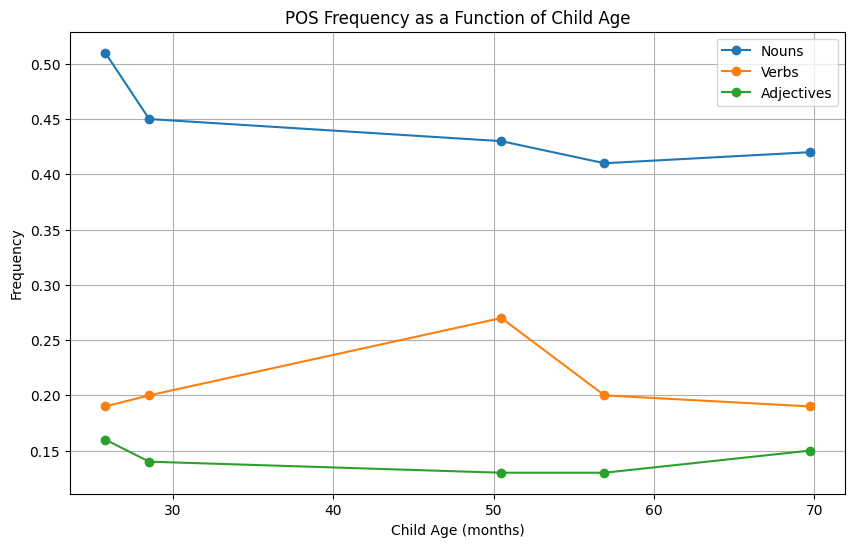

In [549]:
# Plot the frequency of nouns, verbs, and adjectives as a function of child age
# This is a dummy statistic for now - it should be compared with that of parents, etc. to see if it's meaningful

pos_freq_as_child_ages = {
    float(corpora_statistics[name]['avg_age_mo'].values[0]): {
        'nouns': float(corpora_statistics[name]['pct_nouns_chi'].values[0]),
        'verbs': float(corpora_statistics[name]['pct_verbs_chi'].values[0]),
        'adjs' : float(corpora_statistics[name]['pct_adjs_chi' ].values[0])
    } for name in corpora_names
}
pos_freq_as_child_ages = dict(sorted(pos_freq_as_child_ages.items()))

ages  = list(pos_freq_as_child_ages.keys())
nouns = [data['nouns'] for data in pos_freq_as_child_ages.values()]
verbs = [data['verbs'] for data in pos_freq_as_child_ages.values()]
adjs  = [data['adjs' ] for data in pos_freq_as_child_ages.values()]

plt.figure(figsize=(10, 6))
plt.plot(ages, nouns, marker='o', label='Nouns')
plt.plot(ages, verbs, marker='o', label='Verbs')
plt.plot(ages, adjs,  marker='o', label='Adjectives')

plt.xlabel('Child Age (months)')
plt.ylabel('Frequency')
plt.title('POS Frequency as a Function of Child Age')
plt.legend()
plt.grid(True)
plt.show()